# GA DSI Project 3: Chapter 2

# Imports

In [1]:
# unholy trinity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# string cleaning
from bs4 import BeautifulSoup as bs
import re
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# data visualization
from nltk import FreqDist
from matplotlib import cm

# model
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, RocCurveDisplay, f1_score, 
                             roc_auc_score, classification_report, accuracy_score)
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

# Importing Data

In [2]:
df = pd.read_csv("../data/reddit-data.csv")
df.head()

,title,selftext,subreddit
0,What is this buildup?,NaN,winemaking
1,"Added a bit too much water 200ish ml, asked fo...",NaN,winemaking
2,How many vines would you start with?,Hi all- \n\n&amp;#x200B;\n\nWine lover and avi...,winemaking
3,Misc CO2 / Oxygen protection question ...,I have a wine batch that has CO2 naturally dis...,winemaking
4,What's going on in this bottle?,NaN,winemaking


In [3]:
df.subreddit.value_counts()

winemaking     1000
Homebrewing    1000
Name: subreddit, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      2000 non-null   object
 1   selftext   1472 non-null   object
 2   subreddit  2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


In [5]:
df

,title,selftext,subreddit
0,What is this buildup?,NaN,winemaking
1,"Added a bit too much water 200ish ml, asked fo...",NaN,winemaking
2,How many vines would you start with?,Hi all- \n\n&amp;#x200B;\n\nWine lover and avi...,winemaking
3,Misc CO2 / Oxygen protection question ...,I have a wine batch that has CO2 naturally dis...,winemaking
4,What's going on in this bottle?,NaN,winemaking
...,...,...,...
1995,If anyone are woundring about getting into som...,NaN,Homebrewing
1996,Espresso stout,I have a espresso stout 10days into fermentati...,Homebrewing
1997,Can acid additions give bad hangovers? or is i...,So our brews have a tendency to give the drink...,Homebrewing
1998,Free PDF of the first issue of Zymurgy Magazine,NaN,Homebrewing


# Data Processing

## Removing duplicates

In [6]:
df.duplicated().sum()

31

In [7]:
df = df[df.duplicated() == False]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      1969 non-null   object
 1   selftext   1454 non-null   object
 2   subreddit  1969 non-null   object
dtypes: object(3)
memory usage: 61.5+ KB


In [8]:
df.reset_index(drop=True, inplace=True)

## Null values

First, let's look at the null values and what they mean. There are 3 types of missing values:
1. null values
2. `[removed]`
3. `[deleted]`

From this [reddit answer](https://www.reddit.com/r/redditdev/comments/6xo9h4/deleted_vs_removed/), `[removed]` are posts removed by mods, and `[deleted]` are those deleted by the users themselves. This leaves the null values as those which are pictures/videos.

In [9]:
df.isnull().sum()

title          0
selftext     515
subreddit      0
dtype: int64

In [10]:
df[df["selftext"].isnull() == True]

,title,selftext,subreddit
0,What is this buildup?,NaN,winemaking
1,"Added a bit too much water 200ish ml, asked fo...",NaN,winemaking
4,What's going on in this bottle?,NaN,winemaking
7,My first batches of mead are bubbling beautifu...,NaN,winemaking
11,"When bottling, what do you do if you end up no...",NaN,winemaking
...,...,...,...
1899,Anyone in the Midwest want some barrels? Woode...,NaN,Homebrewing
1911,"After 10 years of homebrewing, this Oregon bre...",NaN,Homebrewing
1928,$39.99 ball locks and free gift card if you sp...,NaN,Homebrewing
1964,If anyone are woundring about getting into som...,NaN,Homebrewing


In [11]:
df[df["selftext"] == "[removed]"]

,title,selftext,subreddit
66,Does my primary fermentation pulp look okay?,[removed],winemaking
67,Does this look okay?,[removed],winemaking
105,People of reddit..... What do you think about ...,[removed],winemaking
193,Wine fermentation (grape &amp; cranberries),[removed],winemaking
237,Bottling question,[removed],winemaking
...,...,...,...
1851,Added too much water mistake!,[removed],Homebrewing
1855,Bourbon ale anyone?,[removed],Homebrewing
1872,Pre-Fixed Switch,[removed],Homebrewing
1873,Hombrew a Pre-Fixed Switch,[removed],Homebrewing


There is one more null value, which upon inspection seems to be a miscategorized post - a beer-themed post in a winemaking subreddit. Since there is only one of them, we can remove it to remove clutter.

In [12]:
df[df["selftext"] == "[deleted]"]

,title,selftext,subreddit
197,This Guy Needs A Beer,[deleted],winemaking


In [13]:
df = df[df["selftext"] != "[deleted]"]

There are a total of 611 rows without a `selftext`. Since they are redundant data for our purposes, we can replace them with the null string.

In [14]:
df = df.replace({"[removed]": ""})
df = df.replace(np.nan, "")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1968 entries, 0 to 1968
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      1968 non-null   object
 1   selftext   1968 non-null   object
 2   subreddit  1968 non-null   object
dtypes: object(3)
memory usage: 61.5+ KB


## Combining columns

Since all text data is useful data, we can combine the `title` and `selftext` columns for easier processing.

In [16]:
df['combined'] = df['title'] + ' '+ df['selftext']
df

,title,selftext,subreddit,combined
0,What is this buildup?,,winemaking,What is this buildup?
1,"Added a bit too much water 200ish ml, asked fo...",,winemaking,"Added a bit too much water 200ish ml, asked fo..."
2,How many vines would you start with?,Hi all- \n\n&amp;#x200B;\n\nWine lover and avi...,winemaking,How many vines would you start with? Hi all- \...
3,Misc CO2 / Oxygen protection question ...,I have a wine batch that has CO2 naturally dis...,winemaking,Misc CO2 / Oxygen protection question ... I ha...
4,What's going on in this bottle?,,winemaking,What's going on in this bottle?
...,...,...,...,...
1964,If anyone are woundring about getting into som...,,Homebrewing,If anyone are woundring about getting into som...
1965,Espresso stout,I have a espresso stout 10days into fermentati...,Homebrewing,Espresso stout I have a espresso stout 10days ...
1966,Can acid additions give bad hangovers? or is i...,So our brews have a tendency to give the drink...,Homebrewing,Can acid additions give bad hangovers? or is i...
1967,Free PDF of the first issue of Zymurgy Magazine,,Homebrewing,Free PDF of the first issue of Zymurgy Magazine


## Removing unhelpful data

### Removing unwanted characters

We can start by removing unwanted data:
- '\&amp;\' etc: HTML relics
- punctuation
- '\n' etc: delimiters
- website links: 'unhelpful' as they would add unnecessary noise to our data

We can combine them all into one function for future use.

In [17]:
def text_cleaning(text):
    """
    removes unwanted characters (punctuation, HTML relics, and delimiters) and unwanted data (emails, emojis)
    """
    # removing punctuation, except % which might be used for abv
    punc = re.sub(r"[/%]", "", string.punctuation)
    clean = "".join(l for l in text if l not in punc)

    # remove html
    text = bs(clean)
    clean = text.get_text(strip=True)

    # remove delimiters
    clean = re.sub(r"(\\n)+", " ", clean)

    # remove hyperlinks
    clean = re.sub(r"http\S+|www.\S+", "", clean)

    # lower case
    clean = clean.lower()
    
    return clean

In [18]:
df['combined']=df['combined'].apply(text_cleaning)

We can also change our dependent variable to:
- winemaking: 0
- homebrewing: 1

for easier reference going forward.

In [19]:
df['subreddit'] = df['subreddit'].map({'winemaking':int(0), 'Homebrewing':int(1)})

## Lemmatizing

Next, we can reduce the words to their root form so that we can handle words of a similar root, for example the words "go/going/gone" should be treated in the same way.

To do this more efficiently, we have to provide a Part-of-Speech (POS) tag for each word, so that the lemmatizer knows whether the word is a noun, verb, adverb etc. By default, the lemmatizer recognizes every word as a noun - but the inflection rules for nouns to not apply to verbs, for example.

In [20]:
%%time
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemma(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(text)]
    
df.combined = df.combined.apply(lemma)

CPU times: user 22.1 s, sys: 3.63 s, total: 25.8 s
Wall time: 26.1 s


In [21]:
df

,title,selftext,subreddit,combined
0,What is this buildup?,,0,"[what, be, this, buildup]"
1,"Added a bit too much water 200ish ml, asked fo...",,0,"[add, a, bit, too, much, water, 200ish, ml, as..."
2,How many vines would you start with?,Hi all- \n\n&amp;#x200B;\n\nWine lover and avi...,0,"[how, many, vine, would, you, start, with, hi,..."
3,Misc CO2 / Oxygen protection question ...,I have a wine batch that has CO2 naturally dis...,0,"[misc, co2, /, oxygen, protection, question, i..."
4,What's going on in this bottle?,,0,"[whats, go, on, in, this, bottle]"
...,...,...,...,...
1964,If anyone are woundring about getting into som...,,1,"[if, anyone, be, woundring, about, get, into, ..."
1965,Espresso stout,I have a espresso stout 10days into fermentati...,1,"[espresso, stout, i, have, a, espresso, stout,..."
1966,Can acid additions give bad hangovers? or is i...,So our brews have a tendency to give the drink...,1,"[can, acid, addition, give, bad, hangover, or,..."
1967,Free PDF of the first issue of Zymurgy Magazine,,1,"[free, pdf, of, the, first, issue, of, zymurgy..."


In addition, we can also remove stopwords that would negatively affect our data. We will need to add to our stopwords list to remove additional noise that might affect our model. These will have to be iteratively added as we look at the visualizations below.

In [22]:
# editing default stopwords list
stop_words = set(stopwords.words("english")) | {'hey', 'guys', 'im', 'ive', 
                                                'hello', '2021', 'q', 'question',
                                                '’', 'dont', 'yall', 'get', 'like',
                                               'anyone', 'thread', 'upvote', 'upvotes', 
                                                'work', 'thanks', 'please', 'sure', 'go', 
                                                'would', 'welcome', 'vote', 'reply'}
len(stop_words)

205

In [23]:
# function to remove stopwords
def remove_stopwords(lst):
    return [word for word in lst if word not in stop_words]

df['combined'] = df['combined'].apply(remove_stopwords)
df['combined'] = df['combined'].apply(lambda x: ' '.join(x))

In [24]:
df

,title,selftext,subreddit,combined
0,What is this buildup?,,0,buildup
1,"Added a bit too much water 200ish ml, asked fo...",,0,add bit much water 200ish ml ask 45l 47 reckon...
2,How many vines would you start with?,Hi all- \n\n&amp;#x200B;\n\nWine lover and avi...,0,many vine start hi ampx200b wine lover avid pl...
3,Misc CO2 / Oxygen protection question ...,I have a wine batch that has CO2 naturally dis...,0,misc co2 / oxygen protection wine batch co2 na...
4,What's going on in this bottle?,,0,whats bottle
...,...,...,...,...
1964,If anyone are woundring about getting into som...,,1,woundring kveikfermentation short video lars m...
1965,Espresso stout,I have a espresso stout 10days into fermentati...,1,espresso stout espresso stout 10days fermentat...
1966,Can acid additions give bad hangovers? or is i...,So our brews have a tendency to give the drink...,1,acid addition give bad hangover likely differe...
1967,Free PDF of the first issue of Zymurgy Magazine,,1,free pdf first issue zymurgy magazine


# EDA

## Tokenizing and Stemming

There are various tokenizing, lemmatizing, and vectorizing methods which we can use to analyze the data. The ones we have chosen are:
- `n_grams`: for unigrams/bigrams
- `tf-idf`: for term frequency-inverse document frequency

With these various tools, we will use domain knowledge to see whether our data would be good enough to produce a good classification model.

## Function

We can create a function to store our EDA steps for all the 3 tokenizations.

In [25]:
def freq_plot(df, vec):
    '''
    function to plot the most frequent unigrams, bigrams, and tf-idf given the dataframe (df) and vectorization (vec)
    returns the top 20 most common tokens and their frequency charts
    '''
    
    if vec == 'unigram':
        v = CountVectorizer(ngram_range=(1,2), stop_words=stop_words)
    elif vec == 'bigram':
        v = CountVectorizer(ngram_range=(2,2), stop_words=stop_words)
    elif vec == 'tf-idf unigram':
        v = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
    else:
        v = TfidfVectorizer(ngram_range=(2,2), stop_words=stop_words)
    
    wine = v.fit_transform(df[df['subreddit']==0]['combined'])
    wine = pd.DataFrame(wine.todense(), columns=v.get_feature_names_out()).sum().sort_values().tail(20)
    beer = v.fit_transform(df[df['subreddit']==1]['combined'])
    beer = pd.DataFrame(beer.todense(), columns=v.get_feature_names_out()).sum().sort_values().tail(20)

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    color_wine = cm.Spectral(np.linspace(0, 1, 20))
    color_beer = cm.coolwarm(np.linspace(0, 1, 20))
    plt.suptitle(f'Plots of most frequent {vec}s in the subreddits', fontsize=25)

    axes[0].set_title(f'Top 20 words in winemaking subreddit titles', fontsize = 15)
    axes[0].set_xlabel('Count')
    axes[0].set_ylabel('Words')
    axes[0].barh(wine.index, wine, color=color_wine)

    axes[1].set_title(f'Top 20 words in homebrewing subreddit text', fontsize = 15)
    axes[1].set_xlabel('Count')
    axes[1].set_ylabel('Words')
    axes[1].barh(beer.index, beer, color=color_beer);
    
    return wine, beer

## n-gram Vectorizer

We can first look at a plot of the 20 most common unigrams (single word token) and bigrams (double word token).

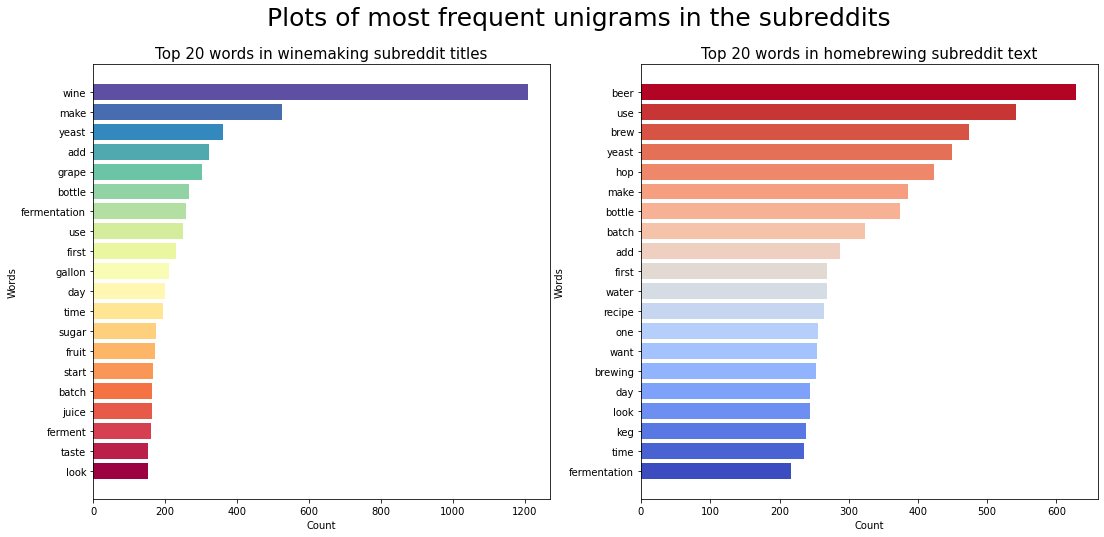

In [26]:
wine_uni, beer_uni = freq_plot(df, vec='unigram')

This time, we can try a bigram splitting.

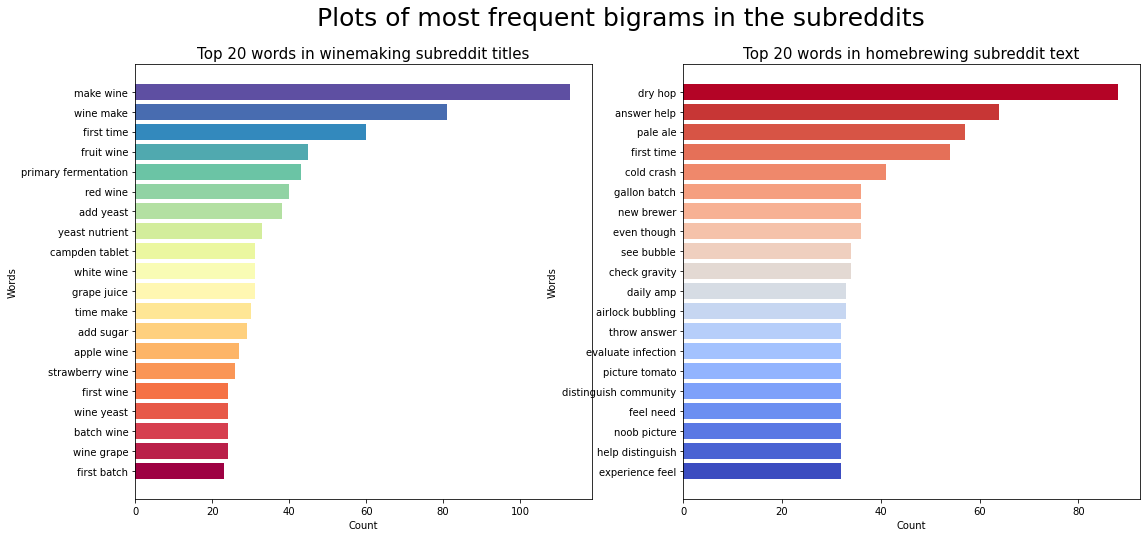

In [27]:
wine_bi, beer_bi = freq_plot(df, 'bigram')

## tf-idf Vectorizer

Lastly, we can take a look at the frequency of words with a tf-idf vectorizer.

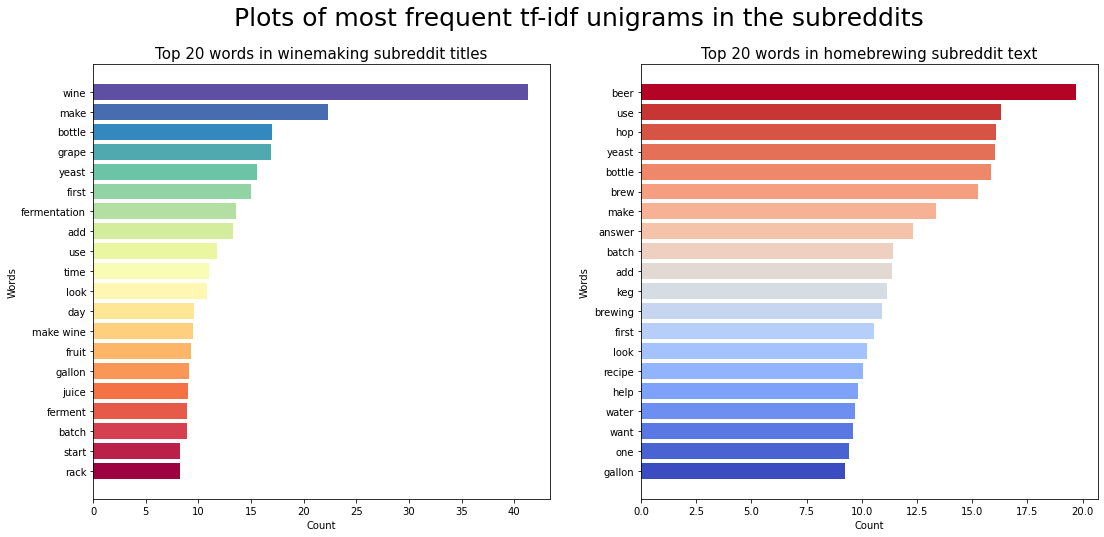

In [28]:
wine_tfidf_uni, beer_tfidf_uni = freq_plot(df, vec='tf-idf unigram')

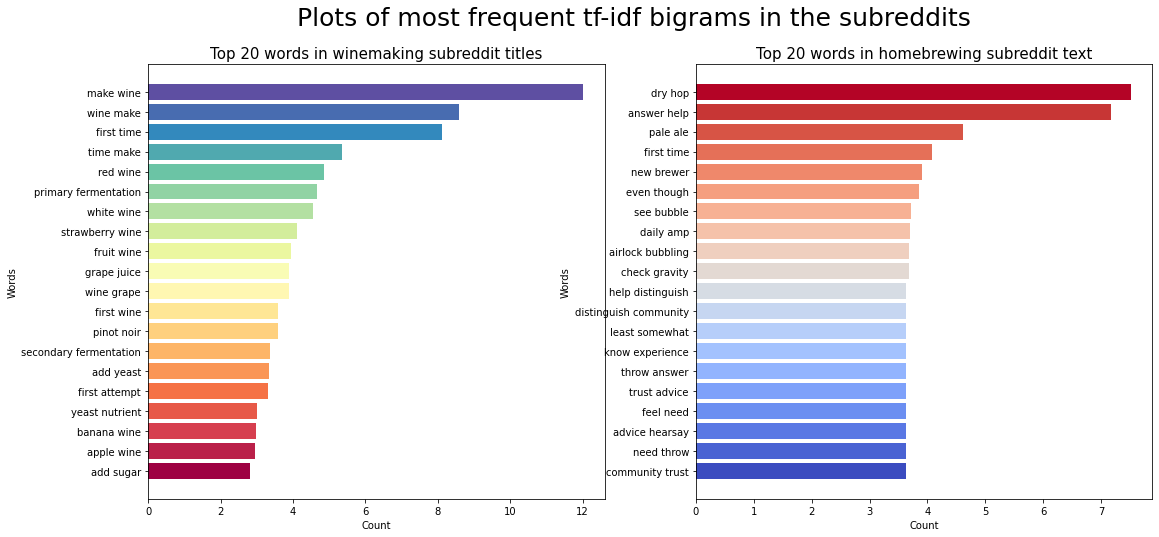

In [29]:
wine_tfidf_bi, beer_tfidf_bi = freq_plot(df, vec='tf-idf bigram')

We can also take a look at the contexts in which the main words, 'wine' and 'beer' occur. This might give us more insight about the contexts of the posts and what people are posting about.

In [30]:
str1 = ''
for i in df.combined:
    str1 = str1+i+' '
combined_text = nltk.Text(word_tokenize(str1))
combined_text.concordance('wine')

Displaying 25 of 1258 matches:
ent fine many vine start hi ampx200b wine lover avid plant grower want grow gr
 grower want grow grape make dry red wine think merlot variety perhaps nebbiol
6b south east pa make mead equipment wine make part love grow plant think mana
 produce enough grape let say510 gal wine per year space isnt huge issue thoug
pointer misc co2 / oxygen protection wine batch co2 naturally dissolve primary
ask concerned oxygen management fact wine still little fizzy prove good job ma
ottle help virtually experience make wine store grape juice want make wine str
ake wine store grape juice want make wine strawberry one make wine fruit stabi
e want make wine strawberry one make wine fruit stabilize wine bulk age gallon
wberry one make wine fruit stabilize wine bulk age gallon carrot various fruit
bulk age gallon carrot various fruit wine several month stabilize wine sweeten
s fruit wine several month stabilize wine sweeten much potassium metabisulfite
 instruction also lon

In [31]:
combined_text.concordance('beer')

Displaying 25 of 673 matches:
perly havent make wine although make beer least indirect familiarity equipment
t first white wine maceration bottle beer growler ready bottle applewine ferme
e save enough bottle whole batch use beer growler cornell winemaking certifica
ctice winemaking learn diacetyl rest beer production raise temperature cold fe
ction raise temperature cold ferment beer closer room temperature 23 day youre
vel well undesirable compound finish beer ferment version practice carry winem
ally want change career home brewing beer consider beer industry however think
ge career home brewing beer consider beer industry however think rather find b
rry fruit tip recipe advice brew lot beer think almost process wine crush boil
ar elderberry doesnt much bottle use beer cap need cork keep mind live small t
day quick way make pinot grigio come beer world beer 2 week brew day look wine
ay make pinot grigio come beer world beer 2 week brew day look wine wife resea
y 34 month way speed p

## Summary

In [32]:
print(set(wine_uni.index.to_list()) & set(beer_uni.index.to_list()))

{'yeast', 'make', 'add', 'day', 'bottle', 'batch', 'use', 'time', 'first', 'fermentation', 'look'}


In [33]:
set(wine_bi.index.to_list()) & set(beer_bi.index.to_list())

{'first time'}

In [34]:
print(set(wine_tfidf_uni.index.to_list())& set(beer_tfidf_uni.index.to_list()))

{'gallon', 'yeast', 'make', 'add', 'bottle', 'batch', 'use', 'first', 'look'}


In [35]:
set(wine_tfidf_bi.index.to_list())& set(beer_tfidf_bi.index.to_list())

{'first time'}

After looking at the various important words and phrases, we can see that the subreddits have sufficient differences in their most frequent words to build a useful model. There are more differences in the bigrams than the unigrams, which might indicate that they would be more useful in training our model to identify the important phrases.

It seems that while 'make wine' appears way more often than 'make beer', the process is split between 'make beer', 'brewing beer', 'ferment beer', and 'homebrewing beer'. More posts seem to be about beer production, while the wine subreddit seems to have some discussion about wine styles. 

We can also see interesting sociolinguistic patterns - there are a number of first time brewers and winemakers who are looking for different styles to make, as 'first time' comes up relatively frequently in both subreddits. There are also more wine styles than beer styles that people are looking for, with wines being made from different fruits, whereas beer is usually beer, ginger beer, root beer or mead.

# Model building

We will be building a range of models with the help of pipelines and GridSearchCV. The models we will be considering are:
- logistic regression:
    * unigrams and bigrams
    * tf-idf
- KNN classifier:
    * unigrams and bigrams
    * tf-idf
- naïve bayes:
    * unigrams and bigrams
    * tf-idf
- random forest:
    * unigrams and bigrams
    * tf-idf

Before that, we have to verify if the target class is balanced.

In [36]:
df.subreddit.value_counts()

0    986
1    982
Name: subreddit, dtype: int64

The classes are roughly balanced (after dropping duplicates), which makes sense as we pulled a roughly equal number of posts for each topic.

## Splitting data

We will first split the training data, making sure to keep the stratification of the $y$ variable the same in the `train` and `test` variables. This ensures that the proportions of the classes would be the same to avoid imbalanced data.

In [37]:
X = df.combined
y = df.subreddit

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## Pipelines

### Logistic Regression

Logistic regression uses a linear regression but with parameters that shape the line of best fit such that it can be considered a classification model. It aims to maximize the likelihood function of the training data, and use that to classify the test data according to its likelihood. In this context, it would be using the count for each word to predict the likelihood of the post being in one subreddit or another.

#### Count vectorizer
We first consider the count vectorizer with logistic regression. We will set `random_state=42` as we do not want different values for each run.

In [38]:
pipe_log_cv = Pipeline(
    [('cv', CountVectorizer()), ("log", LogisticRegression(solver='liblinear', random_state=42))]
)

In [39]:
pipe_log_cv.get_params()

{'memory': None,
 'steps': [('cv', CountVectorizer()),
  ('log', LogisticRegression(random_state=42, solver='liblinear'))],
 'verbose': False,
 'cv': CountVectorizer(),
 'log': LogisticRegression(random_state=42, solver='liblinear'),
 'cv__analyzer': 'word',
 'cv__binary': False,
 'cv__decode_error': 'strict',
 'cv__dtype': numpy.int64,
 'cv__encoding': 'utf-8',
 'cv__input': 'content',
 'cv__lowercase': True,
 'cv__max_df': 1.0,
 'cv__max_features': None,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 1),
 'cv__preprocessor': None,
 'cv__stop_words': None,
 'cv__strip_accents': None,
 'cv__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cv__tokenizer': None,
 'cv__vocabulary': None,
 'log__C': 1.0,
 'log__class_weight': None,
 'log__dual': False,
 'log__fit_intercept': True,
 'log__intercept_scaling': 1,
 'log__l1_ratio': None,
 'log__max_iter': 100,
 'log__multi_class': 'auto',
 'log__n_jobs': None,
 'log__penalty': 'l2',
 'log__random_state': 42,
 'log__solver': 'liblinear',
 'log__tol': 0.0001,


The hyperparameters which we choose to tune are:
- `max_features`: consider only the top $n$ tokens
- `min_df`: min as above (int for no of docs, percentage of docs for float)
- `ngram_range`: consider both a mixture of unigrams and bigrams or just bigrams
- `penalty`: ridge or lasso regression
- `C`: inverse of α, it gives the strength of the regularization (the smaller the stronger, cannot be 0)

In [40]:
log_cv_params = {
    'cv__max_features': [4000, 5000],
    'cv__min_df': [2, 3],
    'cv__ngram_range': [(1,2), (2,2)],
    'log__penalty': ['l1', 'l2'],
    'log__C': np.linspace(0.01, 4.3, 15)
}

We can instantiate our grid search with a 5-fold cross-valuation, splitting the jobs across 5 processors. If there are any errors we will raise them for easier troubleshooting, and we will print the total number of fittings with the `verbose` parameter.

In [41]:
log_cv_gs = GridSearchCV(pipe_log_cv, param_grid=log_cv_params, cv=5, n_jobs=5, error_score='raise', verbose=1)

In [42]:
%time log_cv_gs.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
CPU times: user 3.99 s, sys: 397 ms, total: 4.39 s
Wall time: 1min 4s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('log',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=5,
             param_grid={'cv__max_features': [4000, 5000], 'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 2), (2, 2)],
                         'log__C': array([0.01      , 0.31642857, 0.62285714, 0.92928571, 1.23571429,
       1.54214286, 1.84857143, 2.155     , 2.46142857, 2.76785714,
       3.07428571, 3.38071429, 3.68714286, 3.99357143, 4.3       ]),
                         'log__penalty': ['l1', 'l2']},
             verbose=1)

In [43]:
print(log_cv_gs.best_estimator_)
print(log_cv_gs.best_score_)

Pipeline(steps=[('cv',
                 CountVectorizer(max_features=5000, min_df=2,
                                 ngram_range=(1, 2))),
                ('log',
                 LogisticRegression(C=0.6228571428571429, random_state=42,
                                    solver='liblinear'))])
0.8969038208168643


We can examine the accuracy score with the `.score()` function. Since the classes are balanced, we can simply use the accuracy score, which is the number of correct predictions divided by the total number of predictions. This will only be used to judge whether the model is overfitted or not.

In [44]:
print('Accuracy scores for train and test: ')
print(log_cv_gs.score(X_train, y_train))
print(log_cv_gs.score(X_test, y_test))

Accuracy scores for train and test: 
0.9876543209876543
0.8984771573604061


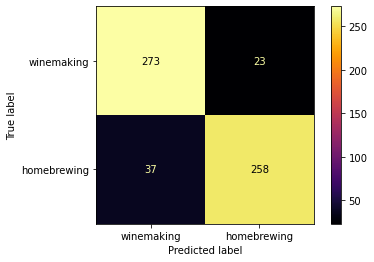

In [45]:
y_pred = log_cv_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='inferno', display_labels=['winemaking', 'homebrewing']);

We will also be plotting a ROC-AUC curve, which shows us the f1 score across various prediction thresholds.. The larger the AUC score, the better the model as it would capture more true positives than false positives, i.e. it would be able to separate the classes better.

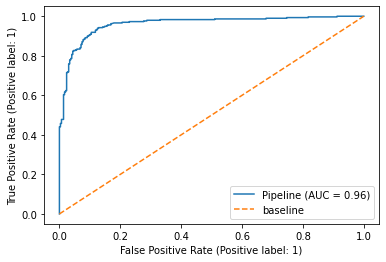

In [46]:
RocCurveDisplay.from_estimator(log_cv_gs.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")
plt.legend();

In [47]:
log_cv_auc = roc_auc_score(y_test, log_cv_gs.best_estimator_.predict_proba(X_test)[:,1])
log_cv_auc

0.9605932203389831

#### tf-idf

In [48]:
pipe_log_tfidf = Pipeline(
    [('tfidf', TfidfVectorizer()), ("log", LogisticRegression(solver='liblinear', random_state=42))]
)

In [49]:
pipe_log_tfidf.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer()),
  ('log', LogisticRegression(random_state=42, solver='liblinear'))],
 'verbose': False,
 'tfidf': TfidfVectorizer(),
 'log': LogisticRegression(random_state=42, solver='liblinear'),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'log__C': 1.0,
 'log__class_weight': None,
 'log__dual': False,
 'log__fit_intercept': True,
 'log__intercept_scaling': 1,
 'log__l1_ratio': None,
 'log__m

The hyperparameters which we choose to tune are:
- `max_features`: consider only the top $n$ tokens
- `min_df`: min as above (int for no of docs, percentage of docs for float)
- `ngram_range`: consider both a mixture of unigrams and bigrams or just bigrams
- `penalty`: ridge or lasso regression
- `C`: inverse of α, it gives the strength of the regularization (the smaller the stronger, cannot be 0)

In [50]:
log_tfidf_params = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__min_df': [2, 3],
    'tfidf__ngram_range': [(1,2), (2,2)],
    'log__penalty': ['l1', 'l2'],
    'log__C': np.linspace(0.1, 4.3, 15)
}

In [51]:
log_tfidf_gs = GridSearchCV(pipe_log_tfidf, param_grid=log_tfidf_params, cv=5, n_jobs=2, error_score='raise', verbose=1)

In [52]:
%time log_tfidf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
CPU times: user 3.35 s, sys: 317 ms, total: 3.67 s
Wall time: 1min 53s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('log',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=2,
             param_grid={'log__C': array([0.1, 0.4, 0.7, 1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7,
       4. , 4.3]),
                         'log__penalty': ['l1', 'l2'],
                         'tfidf__max_features': [4000, 5000],
                         'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 2), (2, 2)]},
             verbose=1)

In [53]:
print(log_tfidf_gs.best_estimator_)
print(log_tfidf_gs.best_score_)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=4000, min_df=2,
                                 ngram_range=(1, 2))),
                ('log',
                 LogisticRegression(C=0.9999999999999999, random_state=42,
                                    solver='liblinear'))])
0.916532279314888


In [54]:
print('Accuracy scores for train and test: ')
print(log_tfidf_gs.score(X_train, y_train))
print(log_tfidf_gs.score(X_test, y_test))

Accuracy scores for train and test: 
0.9767610748002905
0.9120135363790186


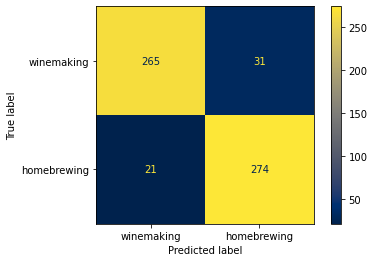

In [55]:
y_pred = log_tfidf_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='cividis', display_labels=['winemaking', 'homebrewing']);

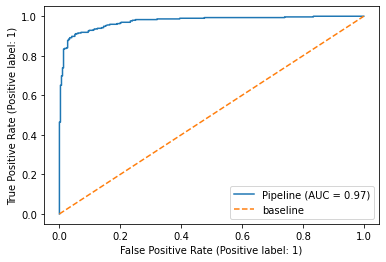

In [56]:
RocCurveDisplay.from_estimator(log_tfidf_gs.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")
plt.legend();

In [57]:
log_tfidf_auc = roc_auc_score(y_test, log_tfidf_gs.best_estimator_.predict_proba(X_test)[:,1])
log_tfidf_auc

0.9745075584058634

### KNN Classifier

The k-nearest neighbor works by using the distance metric between posts to determine where the new post should be classified under. It takes into account word frequency to determine the distance.

#### Count vectorizer

In [58]:
pipe_knn_cv = Pipeline(
    [('cv', CountVectorizer()), ("knn", KNeighborsClassifier())]
)

In [59]:
pipe_knn_cv.get_params()

{'memory': None,
 'steps': [('cv', CountVectorizer()), ('knn', KNeighborsClassifier())],
 'verbose': False,
 'cv': CountVectorizer(),
 'knn': KNeighborsClassifier(),
 'cv__analyzer': 'word',
 'cv__binary': False,
 'cv__decode_error': 'strict',
 'cv__dtype': numpy.int64,
 'cv__encoding': 'utf-8',
 'cv__input': 'content',
 'cv__lowercase': True,
 'cv__max_df': 1.0,
 'cv__max_features': None,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 1),
 'cv__preprocessor': None,
 'cv__stop_words': None,
 'cv__strip_accents': None,
 'cv__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cv__tokenizer': None,
 'cv__vocabulary': None,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

The hyperparameters which we choose to tune are:
- `max_features`: consider only the top $n$ tokens
- `min_df`: min as above (int for no of docs, percentage of docs for float)
- `ngram_range`: consider both a mixture of unigrams and bigrams or just bigrams
- `metric`: whether to measure distances by minkowski or euclidean metric
- `neighbors`: how many nearest neighbors to consider
- `weights`: whether to add additional weights to further points

In [60]:
knn_cv_params = {
    'cv__max_features': [4000, 5000],
    'cv__min_df': [2, 3],
    'cv__ngram_range': [(1,2), (2,2)],
    'knn__metric': ['minkowski', 'euclidean'],
    'knn__n_neighbors': np.arange(5, 12, 2),
    'knn__weights': ['uniform', 'distance']
}

In [61]:
knn_cv_gs = GridSearchCV(pipe_knn_cv, param_grid=knn_cv_params, cv=5, n_jobs=2, error_score='raise', verbose=1)
%time knn_cv_gs.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
CPU times: user 1.68 s, sys: 155 ms, total: 1.84 s
Wall time: 1min 2s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=2,
             param_grid={'cv__max_features': [4000, 5000], 'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 2), (2, 2)],
                         'knn__metric': ['minkowski', 'euclidean'],
                         'knn__n_neighbors': array([ 5,  7,  9, 11]),
                         'knn__weights': ['uniform', 'distance']},
             verbose=1)

In [62]:
print(knn_cv_gs.best_estimator_)
print(knn_cv_gs.best_score_)

Pipeline(steps=[('cv',
                 CountVectorizer(max_features=4000, min_df=3,
                                 ngram_range=(1, 2))),
                ('knn', KNeighborsClassifier(weights='distance'))])
0.7203978919631094


In [63]:
print('Accuracy scores for train and test: ')
print(knn_cv_gs.score(X_train, y_train))
print(knn_cv_gs.score(X_test, y_test))

Accuracy scores for train and test: 
0.9992737835875091
0.727580372250423


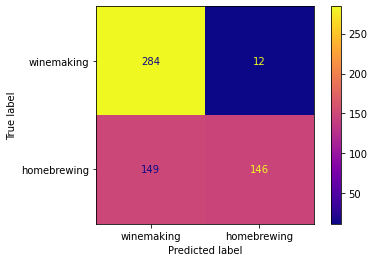

In [64]:
y_pred = knn_cv_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='plasma', display_labels=['winemaking', 'homebrewing']);

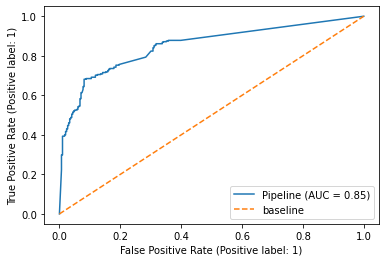

In [65]:
RocCurveDisplay.from_estimator(knn_cv_gs.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")
plt.legend();

In [66]:
knn_cv_auc = roc_auc_score(y_test, knn_cv_gs.best_estimator_.predict_proba(X_test)[:,1])
knn_cv_auc

0.8505611543747138

#### tf-idf

In [67]:
pipe_knn_tfidf = Pipeline(
    [('tfidf', TfidfVectorizer()), ("knn", KNeighborsClassifier())]
)

In [68]:
pipe_knn_tfidf.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer()), ('knn', KNeighborsClassifier())],
 'verbose': False,
 'tfidf': TfidfVectorizer(),
 'knn': KNeighborsClassifier(),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

The hyperparameters which we choose to tune are:
- `max_features`: consider only the top $n$ tokens
- `min_df`: min as above (int for no of docs, percentage of docs for float)
- `ngram_range`: consider both a mixture of unigrams and bigrams or just bigrams
- `metric`: whether to measure distances by minkowski or euclidean metric
- `neighbors`: how many nearest neighbors to consider
- `weights`: whether to add additional weights to further points

In [69]:
knn_tfidf_params = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__min_df': [2, 3],
    'tfidf__ngram_range': [(1,2), (2,2)],
    'knn__metric': ['minkowski', 'euclidean'],
    'knn__n_neighbors': np.arange(5, 12, 2),
    'knn__weights': ['uniform', 'distance']
}

In [70]:
knn_tfidf_gs = GridSearchCV(pipe_knn_tfidf, param_grid=knn_tfidf_params, cv=5, n_jobs=2, error_score='raise', verbose=1)
%time knn_tfidf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
CPU times: user 1.71 s, sys: 156 ms, total: 1.86 s
Wall time: 1min 1s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=2,
             param_grid={'knn__metric': ['minkowski', 'euclidean'],
                         'knn__n_neighbors': array([ 5,  7,  9, 11]),
                         'knn__weights': ['uniform', 'distance'],
                         'tfidf__max_features': [4000, 5000],
                         'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 2), (2, 2)]},
             verbose=1)

In [71]:
print(knn_tfidf_gs.best_estimator_)
print(knn_tfidf_gs.best_score_)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=4000, min_df=3,
                                 ngram_range=(2, 2))),
                ('knn', KNeighborsClassifier(weights='distance'))])
0.5795098814229249


In [72]:
print('Accuracy scores for train and test: ')
print(knn_tfidf_gs.score(X_train, y_train))
print(knn_tfidf_gs.score(X_test, y_test))

Accuracy scores for train and test: 
0.8779956427015251
0.5786802030456852


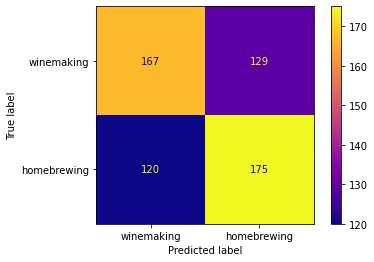

In [73]:
y_pred = knn_tfidf_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='plasma', display_labels=['winemaking', 'homebrewing']);

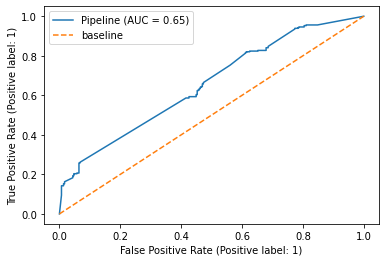

In [74]:
RocCurveDisplay.from_estimator(knn_tfidf_gs.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")
plt.legend();

In [75]:
knn_tfidf_auc = roc_auc_score(y_test, knn_tfidf_gs.best_estimator_.predict_proba(X_test)[:,1])
knn_tfidf_auc

0.6547869903802106

### Naive Bayes

Naïve bayes uses the bayseian conditional probability of each word occurrence to determine which class a new post should be under, given the occurrence of words in the post. There are three types of naïve bayes models, but we will be using the Bernoulli model since our target variable is binary.

#### Count vectorizer

In [76]:
pipe_nb_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('nb', BernoulliNB())
])

In [77]:
pipe_nb_cv.get_params()

{'memory': None,
 'steps': [('cv', CountVectorizer()), ('nb', BernoulliNB())],
 'verbose': False,
 'cv': CountVectorizer(),
 'nb': BernoulliNB(),
 'cv__analyzer': 'word',
 'cv__binary': False,
 'cv__decode_error': 'strict',
 'cv__dtype': numpy.int64,
 'cv__encoding': 'utf-8',
 'cv__input': 'content',
 'cv__lowercase': True,
 'cv__max_df': 1.0,
 'cv__max_features': None,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 1),
 'cv__preprocessor': None,
 'cv__stop_words': None,
 'cv__strip_accents': None,
 'cv__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cv__tokenizer': None,
 'cv__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__binarize': 0.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

The hyperparameters which we choose to tune are:
- `max_features`: consider only the top $n$ tokens
- `min_df`: min as above (int for no of docs, percentage of docs for float)
- `ngram_range`: consider both a mixture of unigrams and bigrams or just bigrams
- `alpha`: Laplace smoothing parameter

In [78]:
nb_cv_params = {
    'cv__max_features': [4000, 5000],
    'cv__min_df': [2, 3],
    'cv__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(1, 21, 20)
}

In [79]:
nb_cv_gs = GridSearchCV(pipe_nb_cv, param_grid=nb_cv_params, cv=5, n_jobs=2, error_score='raise', verbose=1)
%time nb_cv_gs.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
CPU times: user 1.14 s, sys: 101 ms, total: 1.24 s
Wall time: 52.6 s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('nb', BernoulliNB())]),
             n_jobs=2,
             param_grid={'cv__max_features': [4000, 5000], 'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 1), (1, 2)],
                         'nb__alpha': array([ 1.        ,  2.05263158,  3.10526316,  4.15789474,  5.21052632,
        6.26315789,  7.31578947,  8.36842105,  9.42105263, 10.47368421,
       11.52631579, 12.57894737, 13.63157895, 14.68421053, 15.73684211,
       16.78947368, 17.84210526, 18.89473684, 19.94736842, 21.        ])},
             verbose=1)

In [80]:
print(nb_cv_gs.best_estimator_)
print(nb_cv_gs.best_score_)

Pipeline(steps=[('cv', CountVectorizer(max_features=4000, min_df=3)),
                ('nb', BernoulliNB())])
0.7886693017127799


In [81]:
print('Accuracy scores for train and test: ')
print(nb_cv_gs.score(X_train, y_train))
print(nb_cv_gs.score(X_test, y_test))

Accuracy scores for train and test: 
0.8213507625272332
0.8037225042301185


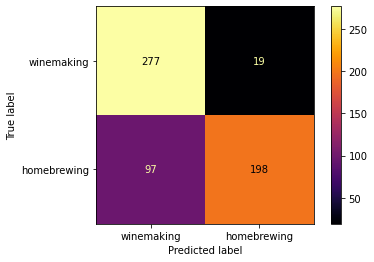

In [82]:
y_pred = nb_cv_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='inferno', display_labels=['winemaking', 'homebrewing']);

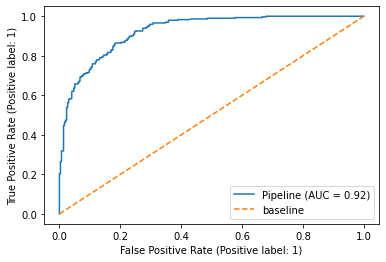

In [83]:
RocCurveDisplay.from_estimator(nb_cv_gs.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")
plt.legend();

In [84]:
nb_cv_auc = roc_auc_score(y_test, nb_cv_gs.best_estimator_.predict_proba(X_test)[:,1])
nb_cv_auc

0.9245877233165368

#### tf-idf

In [85]:
pipe_nb_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', BernoulliNB())
])

In [86]:
pipe_nb_tfidf.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer()), ('nb', BernoulliNB())],
 'verbose': False,
 'tfidf': TfidfVectorizer(),
 'nb': BernoulliNB(),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__binarize': 0.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

The hyperparameters which we choose to tune are:
- `max_features`: consider only the top $n$ tokens
- `min_df`: min as above (int for no of docs, percentage of docs for float)
- `ngram_range`: consider both a mixture of unigrams and bigrams or just bigrams
- `alpha`: Laplace smoothing parameter

In [87]:
nb_tfidf_params = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__min_df': [2, 3],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(1, 21, 20)
}

In [88]:
nb_tfidf_gs = GridSearchCV(pipe_nb_tfidf, param_grid=nb_tfidf_params, cv=5, n_jobs=2, error_score='raise', verbose=1)
%time nb_tfidf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
CPU times: user 1.23 s, sys: 106 ms, total: 1.33 s
Wall time: 54.7 s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', BernoulliNB())]),
             n_jobs=2,
             param_grid={'nb__alpha': array([ 1.        ,  2.05263158,  3.10526316,  4.15789474,  5.21052632,
        6.26315789,  7.31578947,  8.36842105,  9.42105263, 10.47368421,
       11.52631579, 12.57894737, 13.63157895, 14.68421053, 15.73684211,
       16.78947368, 17.84210526, 18.89473684, 19.94736842, 21.        ]),
                         'tfidf__max_features': [4000, 5000],
                         'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [89]:
print(nb_tfidf_gs.best_estimator_)
print(nb_tfidf_gs.best_score_)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=4000, min_df=3)),
                ('nb', BernoulliNB())])
0.7886693017127799


In [90]:
print('Accuracy scores for train and test: ')
print(nb_tfidf_gs.score(X_train, y_train))
print(nb_tfidf_gs.score(X_test, y_test))

Accuracy scores for train and test: 
0.8213507625272332
0.8037225042301185


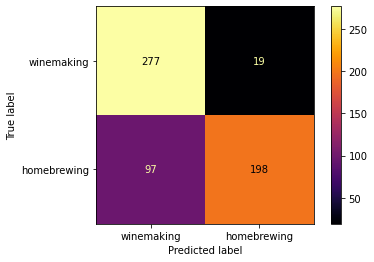

In [91]:
y_pred = nb_tfidf_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='inferno', display_labels=['winemaking', 'homebrewing']);

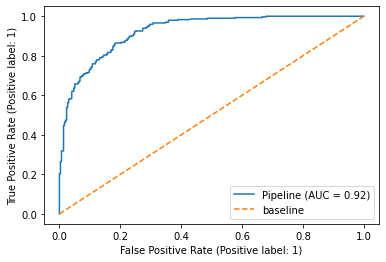

In [92]:
RocCurveDisplay.from_estimator(nb_tfidf_gs.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")
plt.legend();

In [93]:
nb_tfidf_auc = roc_auc_score(y_test, nb_tfidf_gs.best_estimator_.predict_proba(X_test)[:,1])
nb_tfidf_auc

0.9245877233165368

### Random Forest

The random forest model is an aggregated bagging of decision trees, which determines the classification of a new post given its probability of occurrence in a new post. This aggregation reduces the variance, but might lead to overfitting. It is also not as computationally efficient as the previous models.

#### Count vectorizer

In [94]:
pipe_rf_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

In [95]:
pipe_rf_cv.get_params()

{'memory': None,
 'steps': [('cv', CountVectorizer()),
  ('rf', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'cv': CountVectorizer(),
 'rf': RandomForestClassifier(random_state=42),
 'cv__analyzer': 'word',
 'cv__binary': False,
 'cv__decode_error': 'strict',
 'cv__dtype': numpy.int64,
 'cv__encoding': 'utf-8',
 'cv__input': 'content',
 'cv__lowercase': True,
 'cv__max_df': 1.0,
 'cv__max_features': None,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 1),
 'cv__preprocessor': None,
 'cv__stop_words': None,
 'cv__strip_accents': None,
 'cv__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cv__tokenizer': None,
 'cv__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimator

The hyperparameters which we choose to tune are:
- `max_features`: consider only the top $n$ tokens
- `min_df`: min as above (int for no of docs, percentage of docs for float)
- `ngram_range`: consider both a mixture of unigrams and bigrams or just bigrams
- `max_depth`: the maximum depth of the trees
- `ccp_alpha`: the cost-complexity parameter which prevents overfitting
- `n_estimators`: the number of trees in the forest

In [96]:
rf_cv_params = {
    'cv__max_features': [4000, 5000],
    'cv__min_df': [2, 3],
    'cv__ngram_range': [(1,2), (2,2)],
    'rf__max_depth': np.linspace(11, 15, 5),
    'rf__ccp_alpha': [0,1],
    'rf__n_estimators': np.linspace(400, 800, 5).astype(int)
}

In [97]:
rf_cv_gs = GridSearchCV(pipe_rf_cv, param_grid=rf_cv_params, cv=5, n_jobs=5, error_score='raise', verbose=1)
%time rf_cv_gs.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 9.83 s, sys: 761 ms, total: 10.6 s
Wall time: 14min 47s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=5,
             param_grid={'cv__max_features': [4000, 5000], 'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 2), (2, 2)],
                         'rf__ccp_alpha': [0, 1],
                         'rf__max_depth': array([11., 12., 13., 14., 15.]),
                         'rf__n_estimators': array([400, 500, 600, 700, 800])},
             verbose=1)

In [98]:
print(rf_cv_gs.best_estimator_)
print(rf_cv_gs.best_score_)

Pipeline(steps=[('cv',
                 CountVectorizer(max_features=4000, min_df=2,
                                 ngram_range=(1, 2))),
                ('rf',
                 RandomForestClassifier(ccp_alpha=0, max_depth=12.0,
                                        n_estimators=500, random_state=42))])
0.8903530961791832


In [99]:
print('Accuracy scores for train and test: ')
print(rf_cv_gs.score(X_train, y_train))
print(rf_cv_gs.score(X_test, y_test))

Accuracy scores for train and test: 
0.9179375453885258
0.8950930626057529


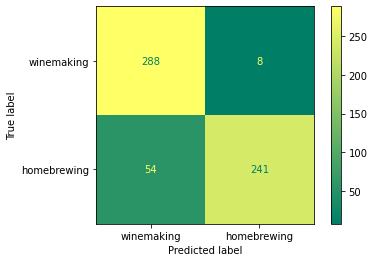

In [100]:
y_pred = rf_cv_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='summer', display_labels=['winemaking', 'homebrewing']);

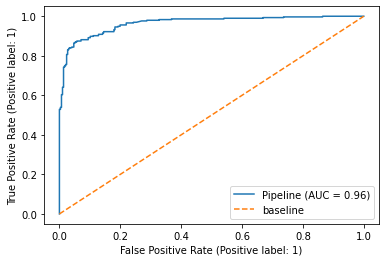

In [101]:
RocCurveDisplay.from_estimator(rf_cv_gs.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")
plt.legend();

In [102]:
rf_cv_auc = roc_auc_score(y_test, rf_cv_gs.predict_proba(X_test)[:,1])
rf_cv_auc

0.9643953275309207

#### tf-idf

In [103]:
pipe_rf_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

In [104]:
pipe_rf_tfidf.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer()),
  ('rf', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(),
 'rf': RandomForestClassifier(random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__ma

The hyperparameters which we choose to tune are:
- `max_features`: consider only the top $n$ tokens
- `min_df`: min as above (int for no of docs, percentage of docs for float)
- `ngram_range`: consider both a mixture of unigrams and bigrams or just bigrams
- `max_depth`: the maximum depth of the trees
- `ccp_alpha`: the cost-complexity parameter which prevents overfitting
- `n_estimators`: the number of trees in the forest

In [105]:
rf_tfidf_params = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__min_df': [2, 3],
    'tfidf__ngram_range': [(1,2), (2,2)],
    'rf__max_depth': np.linspace(10, 14, 5),
    'rf__ccp_alpha': [0,1],
    'rf__n_estimators': np.linspace(400, 800, 5).astype(int)
}

In [106]:
rf_tfidf_gs = GridSearchCV(pipe_rf_tfidf, param_grid=rf_tfidf_params, cv=5, n_jobs=5, error_score='raise', verbose=1)
%time rf_tfidf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 10.3 s, sys: 665 ms, total: 11 s
Wall time: 15min 19s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=5,
             param_grid={'rf__ccp_alpha': [0, 1],
                         'rf__max_depth': array([10., 11., 12., 13., 14.]),
                         'rf__n_estimators': array([400, 500, 600, 700, 800]),
                         'tfidf__max_features': [4000, 5000],
                         'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 2), (2, 2)]},
             verbose=1)

In [107]:
print(rf_tfidf_gs.best_estimator_)
print(rf_tfidf_gs.best_score_)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=4000, min_df=3,
                                 ngram_range=(1, 2))),
                ('rf',
                 RandomForestClassifier(ccp_alpha=0, max_depth=14.0,
                                        n_estimators=700, random_state=42))])
0.8881739130434783


In [108]:
print('Accuracy scores for train and test: ')
print(rf_tfidf_gs.score(X_train, y_train))
print(rf_tfidf_gs.score(X_test, y_test))

Accuracy scores for train and test: 
0.9331880900508351
0.9069373942470389


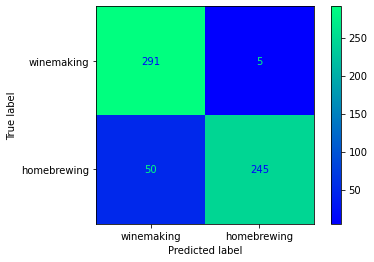

In [109]:
y_pred = rf_tfidf_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='winter', display_labels=['winemaking', 'homebrewing']);

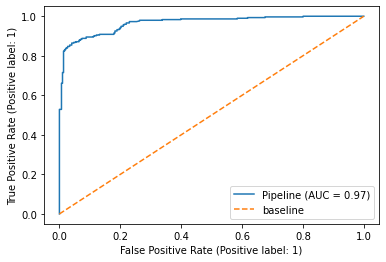

In [110]:
RocCurveDisplay.from_estimator(rf_tfidf_gs.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")
plt.legend();

In [111]:
rf_tfidf_auc = roc_auc_score(y_test, rf_tfidf_gs.best_estimator_.predict_proba(X_test)[:,1])
rf_tfidf_auc

0.9659356390288594

# Model Analysis

## Model metrics

Before we analyze the model scores, we can first generate a baseline score. This will be a naive count of the proportion of each category in the training data.

In [112]:
df.subreddit.value_counts(normalize=True)

0    0.501016
1    0.498984
Name: subreddit, dtype: float64

Understandably, since we obtained roughly equal portions of data (minus duplicates) of each subreddit, this means that naive prediction should give an almost equal chance of classifying any new data as one topic or the other. This is a terrible prediction score which we hope to beat with our models.

We can put our models into a dataframe for easier reference.

In [135]:
models = ['Logistic Regression', 'Logistic Regression', 'KNN Classifier', 'KNN Classifier', 'Naïve Bayes', 'Naïve Bayes', 'Random Forest', 'Random Forest']
vectorizer = ['count', 'tf-idf']*4
f1 = [log_cv_gs, log_tfidf_gs, knn_cv_gs, knn_tfidf_gs, nb_cv_gs, nb_tfidf_gs, rf_cv_gs, rf_tfidf_gs]
score = [i.best_score_ for i in f1]
auc = [log_cv_auc, log_tfidf_auc, knn_cv_auc, knn_tfidf_auc, nb_cv_auc, nb_tfidf_auc, rf_cv_auc, rf_tfidf_auc]
pd.DataFrame(list(zip(models, vectorizer, score, auc)), columns = ['models', 'vectorizer', 'accuracy score', 'auc score']).round(3)

,models,vectorizer,accuracy score,auc score
0,Logistic Regression,count,0.897,0.961
1,Logistic Regression,tf-idf,0.917,0.975
2,KNN Classifier,count,0.720,0.851
3,KNN Classifier,tf-idf,0.580,0.655
4,Naïve Bayes,count,0.789,0.925
5,Naïve Bayes,tf-idf,0.789,0.925
6,Random Forest,count,0.890,0.964
7,Random Forest,tf-idf,0.888,0.966


The ROC-AUC score is the most robust way of determining a good model (that we have learnt thus far), because the closer to 1, the better the model is at separating the two classes. It aims to find the ratio between the sensitivity (true positive rate) and the specificity (true negative rate), which is exactly what we need. Furthermore, the ROC is insensitive to class disparities and thus suited for our balanced classes (Kuhn, Max and Johnson, Kjell, "Applied Predictive Modeling", 2013). 

According to that metric our two best models are:
1. Logistic regression with tf-idf vectorizer
2. Random forest with tf-idf vectorizer

We can further compare these models to see their degree of overfitting, which we can see via their accuracy scores on the train and test datasets, since our classes are balanced.

In [123]:
print('Accuracy scores for logistic regression with tf-idf: ')
print(f'train: {log_tfidf_gs.score(X_train, y_train)}')
print(f'test: {log_tfidf_gs.score(X_test, y_test)}')

Accuracy scores for logistic regression with tf-idf: 
train: 0.9767610748002905
test: 0.9120135363790186


In [122]:
print('Accuracy scores for random forest with count: ')
print(f'train: {rf_tfidf_gs.score(X_train, y_train)}')
print(f'test: {rf_tfidf_gs.score(X_test, y_test)}')

Accuracy scores for random forest with count: 
train: 0.9331880900508351
test: 0.9069373942470389


The random forest model is less overfitted than the logistic regression model, but the latter has a good bias-variance tradeoff. We also see that the logistic regression model's accuracy score of 0.92 is significantly better than the baseline score of 0.5. We can thus conclude that the best model for our purposes is the **logistic regression with tf-idf vectorizer**.

## Corpus analysis

We can also print the misclassified posts to look at the texts that the model misclassified to hopefully get some insights into the type of words the model wrongly classified. These words would have contributed to the false positives and negatives in our classification model.

In [119]:
pd.options.display.max_colwidth = 300
y_pred = log_tfidf_gs.predict(X_test)
combine = list(zip(X_test, y_test, y_pred))
false = pd.DataFrame(columns = ["text", "actual", "predicted"]) 
for text, actual, prediction in combine:
    if actual != prediction:
        row = pd.DataFrame({'text':[text], 'actual':[actual], 'predicted':[prediction]})
        false = false.append(row, ignore_index=True)
for i in ['actual', 'predicted']:
    false[i] = false[i].map({0:'winemaking', 1:'homebrewing'})
false.head()

,text,actual,predicted
0,smart gadget update cool gadgetssmart appliances/ kitchen utensil,homebrewing,winemaking
1,carbon filter airlock pc cool reservoir,homebrewing,winemaking
2,hard cider still taste apple juice first batch hard cider cheap apple juice yeast carboy 10 day bottle small amount sugar bottle let sit 10 day taste taste regular apple juice maybe tiny bite front tell alcohol slightly carbonate expect stay sweet little alcohol taste bubble lot initial ferment ...,homebrewing,winemaking
3,thats co2 right shook container vigorously month old,winemaking,homebrewing
4,white film bottle beer help identify,homebrewing,winemaking


In [120]:
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
mis = tfidf.fit_transform(false['text'])
mis = pd.DataFrame(mis.todense(), columns=tfidf.get_feature_names_out()).sum().sort_values().tail(20)
mis.sort_values(ascending=False)

look         2.092221
bottle       1.691372
wine         1.352732
make         1.074922
bucket       1.073943
gallon       1.069240
add          1.054941
batch        1.012055
use          0.990518
first        0.954669
still        0.889490
help         0.885559
carboy       0.883672
sugar        0.855740
yeast        0.818457
juice        0.784612
also         0.762801
fermenter    0.747630
film         0.728193
try          0.693803
dtype: float64

The top 20 words that the model misclassified seems to be common words, except 'wine' which is surprising. Further analysis could be done on the importance of these words and whether they could be removed as stopwords. Wine might be overclassified due to the type of beer called 'barleywine', or it could be that the beer homebrewers like to compare their process to fermenting wine. Overlapping words like 'sugar' and 'yeast', essential to the general fermentation process, also featured highly, understandably so.

We can also compare the coefficients of the top 20 and bottom 20 words to see the words that the model got correct, which contributed to the true positives and negatives.

In [132]:
coef_names = log_tfidf_gs.best_estimator_.named_steps.tfidf.get_feature_names_out()
coef_vals = np.exp(log_tfidf_gs.best_estimator_.named_steps.log.coef_[0])

coef_df = pd.DataFrame ({
    'word' : coef_names,
    'coef' : coef_vals}).set_index('word')

coef_df.reindex(coef_df['coef'].sort_values(ascending=False).index)[:20]

,coef
word,
beer,40.982709
brew,27.174515
hop,17.141200
brewing,10.012325
keg,7.440317
malt,5.816294
ale,5.421691
grain,5.097452
pressure,4.933084


In [133]:
coef_df.reindex(coef_df['coef'].sort_values().index)[:20]

,coef
word,
wine,0.000448
grape,0.046808
winemaking,0.171880
juice,0.271356
brix,0.291097
make wine,0.313762
wine make,0.322745
press,0.330268
skin,0.331489


The coefficients tell us the probability of classification into our classes, in this case the closer to 0 means the post would be classified under winemaking while the closer to 1 would be homebrewing. Obviously the words that would lead to most correct classifications are the topics themselves, 'wine' and 'beer'. There are also topical words which the model got correct like 'hop', 'malt', and 'keg' for beer and 'grape', 'skin', and 'age' for wine. This means that a majority of key words were classified correctly.

# Conclusion and Limitations

We will again show the most frequent word tokens that we used to train our model.

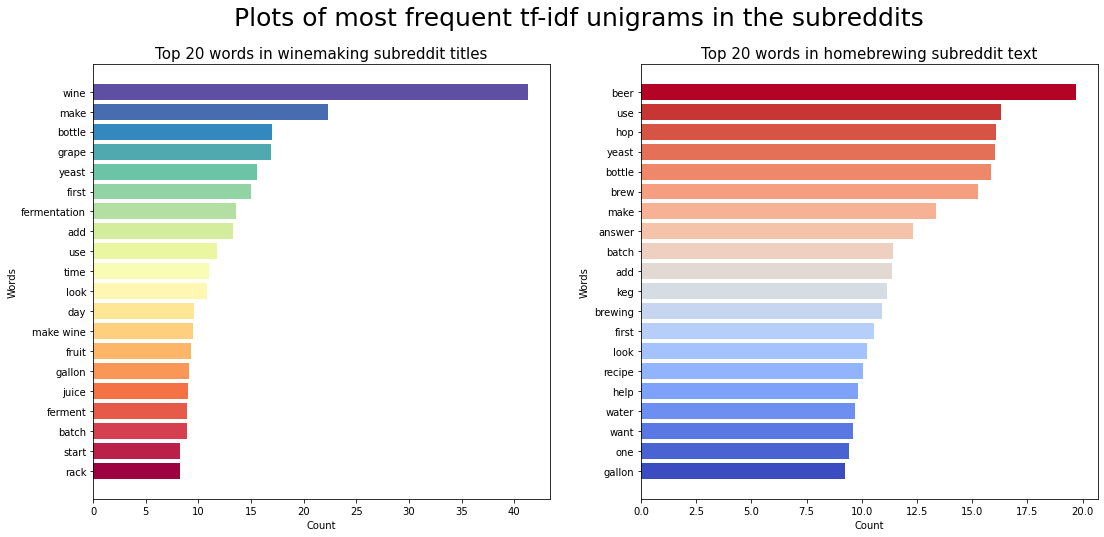

In [118]:
wine_tfidf_uni, beer_tfidf_uni = freq_plot(df, vec='tf-idf unigram')

It seems that the unigram/bigram mix has enough unique tokens to fit our model without too much overfitting. With more data and a more robust cleaning, we are confident that the model can be improved greatly to suit the customer's needs. But in the meantime, we are confident enough to present our model to the client as it has a relatively high score and would be able to sieve out whether any prospective customer would like to know about winemaking or homebrewing.

The overfitting could be addressed by removing more stopwords, and considering the context of the commonly misclassified words. We could also remove the obvious words like 'wine' and 'beer' because they are obvious indicators of the topics, and try to prioritize other adjacent words.

We could improve our model by adding a spell-checker for certain words that are spelt wrongly, which might improve the accuracy of the lemmatizer. Work could also be done in cleaning up emojis and other unwanted data to reduce the noise that goes into the models. These would reduce the overfitting in out best model, which would make it better at predicting new data.

Other models could also be explored like SVM and GLM, but they are outside the scope of this project.